In [97]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [70]:
import tensorflow as tf
tf.executing_eagerly()
from tensorflow.python.keras.applications.vgg19 import VGG19

The include_top parameter is set to False because we dont want the 3 final fully connected layers before the softmax 
function.

In [71]:
model= VGG19(
    include_top=False,
    weights='imagenet'
)

model.trainable=False
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [72]:
from tensorflow.python.keras.preprocessing.image import load_img,img_to_array
from tensorflow.python.keras.applications.vgg19 import preprocess_input
from tensorflow.python.keras.models import Model

import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Image processing

In [73]:
def load_and_process_image(image_path):
    img=load_img(image_path)
    img=img_to_array(img)
    img=preprocess_input(img)
    img=np.expand_dims(img,axis=0)
    return img

In [74]:
def deprocess(x):
    x[:,:,0]+= 103.939
    x[:,:,1]+=116.779
    x[:,:,2]+=123.68
    x=x[:,:,::-1]
    x=np.clip(x,0,255).astype('uint8')
    return x

In [75]:
def display_image(image):
    if len(image.shape)==4:
        img=np.squeeze(image,axis=0)
        
    img=deprocess(img)
    
    plt.grid(False)# hide axes and gridlines
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    return

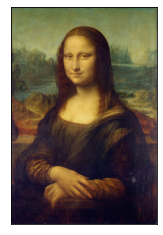

In [98]:
display_image(load_and_process_image('/content/drive/My Drive/Neural Style Transfer/mona.jpg'))

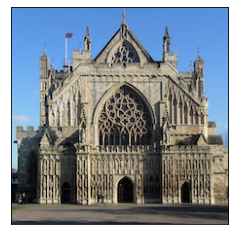

In [77]:
display_image(load_and_process_image('/content/drive/My Drive/Neural Style Transfer/content.jpg'))

# Content and style Models

In [78]:
content_layer='block5_conv2'

style_layers=[
    'block1_conv1',
    'block3_conv1',
    'block5_conv1'
]

content_model=Model(
inputs=model.input,
outputs=model.get_layer(content_layer).output
)


style_models=[Model(inputs=model.input,
                   outputs=model.get_layer(layer).output) for layer in style_layers]

# Content Cost

In [79]:
def content_cost(content,generated):
    a_C=content_model(content)
    a_G=content_model(generated)
    cost=tf.reduce_sum(tf.square(a_C - a_G))
    return cost

# Gram MAtrix

In [80]:
def gram_matrix(A):
    n_C=int(A.shape[-1])
    a=tf.reshape(A,[-1,n_C])
    n=tf.shape(a)[0]
    G=tf.matmul(a,a,transpose_a=True)
    return G/tf.cast(n,tf.float32)

# Style Cost

In [81]:
lam=1. / len(style_models) # weights for different layers(lambda)

def style_cost(style,generated):
    J_style=0
    
    for style_model in style_models:
        a_S=style_model(style)
        a_G=style_model(generated)
        
        GS=gram_matrix(a_S)
        GG=gram_matrix(a_G)
        
        current_cost=tf.reduce_mean(tf.square(GS-GG))
        
        J_style+=current_cost*lam
    
    return J_style

# Cost Optimization

In [99]:
import time
generated_images=[]
noise_ratio=1
def training_loop(content_path,style_path,iterations=100,alpha=50.0,beta=30.0):
    content=load_and_process_image(content_path)
    style=load_and_process_image(style_path)
    
    noise_image = np.random.uniform(-20, 20, (1,224 ,224,3 )).astype('float32')

    generated =noise_image * noise_ratio + content * (1 - noise_ratio)
    generated=tf.Variable(generated,tf.float32)
    opt=tf.compat.v1.train.AdamOptimizer(learning_rate=7.0)
    
    best_cost=1e12 + 0.1
    best_image=None
    
    start_time=time.time()
    
    for i in range(iterations):
        with tf.GradientTape() as tape:
            J_content=content_cost(content,generated)
            J_style=style_cost(style,generated)
            J_total= alpha *J_content + beta*J_style
            
        grads=tape.gradient(J_total,generated)
        
        opt.apply_gradients([(grads,generated)])
        
        if J_total< best_cost:
            best_cost= J_total
            best_image=generated.numpy()
            
        print('Cost at {}: {}. Time elapsed:{}'.format(i,J_total,time.time()-start_time))
        
        generated_images.append(generated.numpy())
        
    return best_image

In [100]:
final=training_loop('/content/drive/My Drive/Neural Style Transfer/content.jpg','/content/drive/My Drive/Neural Style Transfer/mona.jpg')

Cost at 0: 37423366144.0. Time elapsed:15.290172576904297
Cost at 1: 35631726592.0. Time elapsed:19.608340978622437
Cost at 2: 32231659520.0. Time elapsed:23.92892360687256
Cost at 3: 27605495808.0. Time elapsed:28.282891988754272
Cost at 4: 23324375040.0. Time elapsed:32.615901947021484
Cost at 5: 20321861632.0. Time elapsed:36.95661377906799
Cost at 6: 18234851328.0. Time elapsed:41.29812264442444
Cost at 7: 16508804096.0. Time elapsed:45.65521478652954
Cost at 8: 15112745984.0. Time elapsed:49.99988651275635
Cost at 9: 13900959744.0. Time elapsed:54.3678719997406
Cost at 10: 12803658752.0. Time elapsed:58.710373401641846
Cost at 11: 11843106816.0. Time elapsed:63.07370162010193
Cost at 12: 11092532224.0. Time elapsed:67.41464495658875
Cost at 13: 10428703744.0. Time elapsed:71.76545429229736
Cost at 14: 9820889088.0. Time elapsed:76.11480712890625
Cost at 15: 9269931008.0. Time elapsed:80.47517013549805
Cost at 16: 8808266752.0. Time elapsed:84.82074403762817
Cost at 17: 8380240896.

# RESULTS

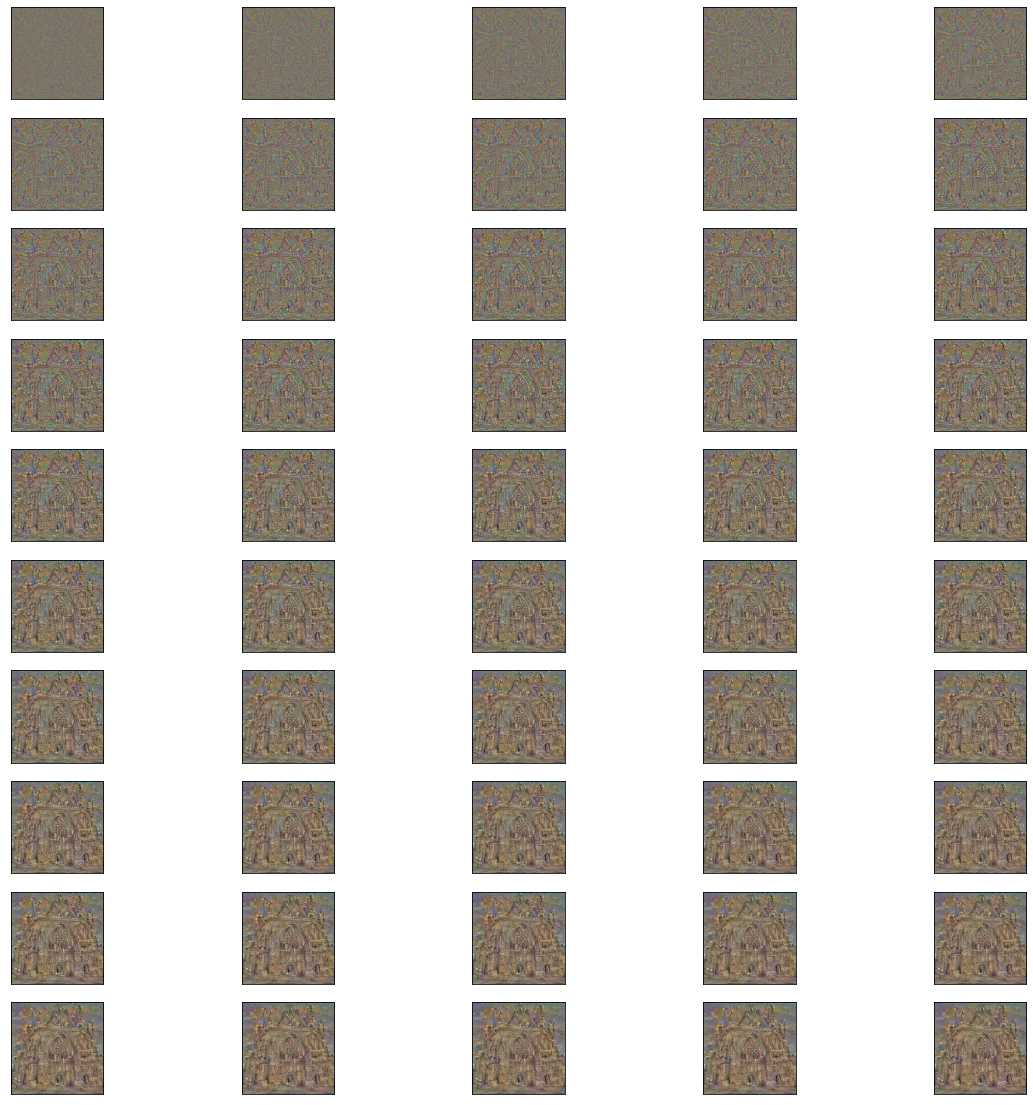

In [101]:
plt.figure(figsize=(20,20))

for i in range(50):
    plt.subplot(10,5,i+1)
    display_image(generated_images[i].copy())

plt.show()

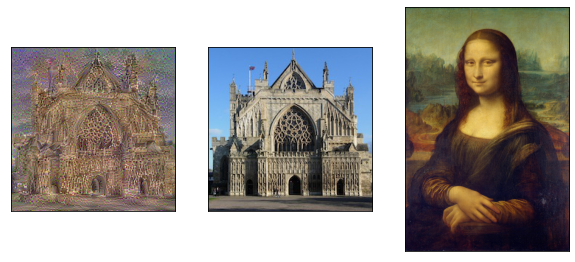

In [102]:
plt.figure(figsize=(10,10))

plt.subplot(1,3,1)
display_image(final.copy())

plt.subplot(1,3,2)
display_image(load_and_process_image('/content/drive/My Drive/Neural Style Transfer/content.jpg'))

plt.subplot(1,3,3)
display_image(load_and_process_image('/content/drive/My Drive/Neural Style Transfer/mona.jpg'))


In [86]:
noise_ratio=1
noise_image = np.random.uniform(-20, 20, (1,224 ,224,3 )).astype('float32')
content=load_and_process_image('/content/drive/My Drive/Neural Style Transfer/content.jpg')
generated =noise_image * noise_ratio + content * (1 - noise_ratio)

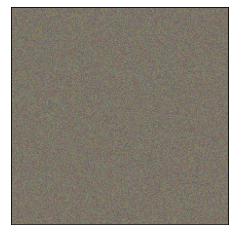

In [87]:
display_image(generated)

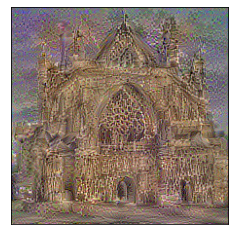

In [103]:
display_image(final.copy())